# INTRODUCTION
This notebook outlines the following steps for downloading basic data:
- 1x1 km grids are created for the Basque Country.

- Data with emissions and geolocation information is downloaded directly from Google Earth.

- The database will begin in June 2018, the first month for which Sentinel-5P data is available.

- Data from the OMI/AURA Project is downloaded for Sentinel-5P level backprojection. The goal is to establish a data series starting from October 2017.

- The first version of the data is made available (without validation or imputation, only original data).

### Preamble
Installing and importing libraries.

In [1]:
#!pip install geopandas
#!pip install earthengine-api
#!pip install geemap
#!pip install relativedelta
#!pip install openpyxl

In [85]:
import geopandas as gpd
from shapely.geometry import box
from shapely.geometry import Point
import numpy as np
import zipfile
import os
import requests
import pandas as pd

import geemap
from datetime import datetime
from dateutil.relativedelta import relativedelta

We establish the working path, leaving the option for execution in **colab** or **local**.

In [3]:
import os
import sys

# If we're in Google Colab
if "google.colab" in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    # Path inside Colab
    BASE_DIR = "/content/data/"
    os.makedirs(BASE_DIR, exist_ok=True)

else:
    # Local path based on the notebook's location
    NOTEBOOK_DIR = os.getcwd() 
    PROJECT_DIR = os.path.dirname(NOTEBOOK_DIR)
    BASE_DIR = os.path.join(PROJECT_DIR, "data")  # project/data/

    os.makedirs(BASE_DIR, exist_ok=True)

In [35]:
# Load utils
import importlib
project_root = os.path.abspath("..")
sys.path.append(project_root)

from src.utils import *
import src.utils as u
importlib.reload(u)

<module 'src.utils' from 'C:\\Users\\camil\\Desktop\\Geospatial_Approach\\src\\utils.py'>

## Data Download

We will download the map of the Basque Country from the GADM Global Database. This is a geographic resource that provides administrative boundaries worldwide for countries and their subdivisions.

### 1. Download map and create grids

In [5]:
# 1. Download the ZIP file from GADM
url = "https://geodata.ucdavis.edu/gadm/gadm4.1/shp/gadm41_ESP_shp.zip"
zip_path = os.path.join(BASE_DIR,"gadm41_ESP_shp.zip")

if not os.path.exists(zip_path):
    print("Downloading...")
    r = requests.get(url)
    with open(zip_path, "wb") as f:
        f.write(r.content)
else:
    print("ZIP already downloaded.")


ZIP already downloaded.


In [6]:
# 2. Extract the ZIP file
extract_dir = os.path.join(BASE_DIR, "gadm41_ESP_shp")

# Create folder if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

#### Loading the Shapefile

A shapefile is a vector geospatial data format widely used in Geographic Information Systems (GIS). Esri developed it to store the location, shape, and attributes of geographic features. A shapefile is not a single file, but a set of related files that work together to define a geographic layer.

Main components of a shapefile:

- .shp: Contains the geometry of the features (points, lines, polygons).

- .shx: An index file that allows for quick searches within the .shp file.

- .dbf: A dBASE table that stores the attributes (descriptive information) of each feature. 

In [7]:
# 3. Load shapefile and filter Basque Country
shp_path = os.path.join(BASE_DIR,"gadm41_ESP_shp/gadm41_ESP_1.shp")
gdf = gpd.read_file(shp_path)
pais_vasco = gdf[gdf["NAME_1"].str.lower().str.contains("vasco|basque")].copy()

In [8]:
# 4. Reproject to metric coordinates (to work with 1km cells)
pais_vasco = pais_vasco.to_crs(epsg=25830)  # UTM Zone 30N

In [9]:
# 5. Save
output_path = os.path.join(BASE_DIR, "pais_vasco.shp")

pais_vasco.to_file(output_path)

In [10]:
# Verify
pais_vasco

,GID_1,GID_0,COUNTRY,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,ISO_1,geometry
15,ESP.16_1,ESP,Spain,País Vasco,Basque Country|Baskenland|Basque,NA,Comunidad Autónoma,Autonomous Community,16,ES.PV,NA,"MULTIPOLYGON (((528223.332 4705799.236, 527460..."


In [11]:
# We use the GeoDataFrame `pais_vasco` which is already loaded (EPSG:25830)

# Extract limits
minx, miny, maxx, maxy = pais_vasco.total_bounds
cell_size = 1000  # 1 km en meters

# Create cell grid
grid_cells = []
for x in np.arange(minx, maxx, cell_size):
    for y in np.arange(miny, maxy, cell_size):
        cell = box(x, y, x + cell_size, y + cell_size)
        grid_cells.append(cell)

# Create GeoDataFrame with the complete grid
grid = gpd.GeoDataFrame(geometry=grid_cells, crs=pais_vasco.crs)

# Cut out only cells that intersect with the Basque Country
grid_clip = gpd.overlay(grid, pais_vasco, how='intersection')
grid_clip["grid_id"] = range(len(grid_clip))
# Save
output_path = os.path.join(BASE_DIR, "grilla_1km_pais_vasco.geojson")
grid_clip.to_file(output_path, driver="GeoJSON")

print(f"{len(grid_clip)} of 1x1 km were created.")

7718 of 1x1 km were created.


In [12]:
# Load original grid
grid = gpd.read_file(output_path)

# export grid_id + geometry
output_path2= os.path.join(BASE_DIR, "grid_id_geometria.gpkg")
grid[['grid_id', 'geometry']].to_file(output_path2, driver="GPKG")

In [13]:
# create centroids
grid_centroids = grid.copy()
grid_centroids["geometry"] = grid_centroids.centroid

# Extract lat/lon for CSV type table
grid_centroids = grid_centroids.to_crs(epsg=4326)
grid_centroids["lon"] = grid_centroids.geometry.x
grid_centroids["lat"] = grid_centroids.geometry.y

# Export as CSV
output_path3= os.path.join(BASE_DIR, "grid_id_centroides.csv")
grid_centroids[["grid_id", "lat", "lon"]].to_csv(output_path3, index=False)

### 2. Downloading Emissions COPERNICUS GOOGLE EARTH

#### Connecting to Google Earth
We will download the emissions from this platform. It is necessary to have previously initialized a project in Google Earth.

For this data download, we will connect to the following projects: **COPERNICUS/S5P/OFFL/.**

In [14]:
# Autentification in GoogleEarth
import ee
ee.Authenticate()
ee.Initialize()

In [15]:
# Initialize Earth Engine
ee.Initialize()

# Load the grid
grid = gpd.read_file(output_path)
points = grid.copy()
points["geometry"] = points["geometry"].centroid
points = points.to_crs(epsg=4326)

fc = geodf_to_fc(points)

### Explanation: Converting from a native 3.5 x 7 km pixel to our 1 x 1 km grids

Not all 1x1 km cells that "fall" within a native 3.5x7 km pixel will necessarily receive the exact same average emission value (e.g., CO). However, the information received by those 1x1 km cells is derived directly from that larger pixel (and adjacent pixels if there is overlap).

**How ​​reduceRegions works with different resolutions**: The code uses *co.reduceRegions(collection=fc_chunk, reducer=ee.Reducer.mean(), scale=1000)*. Let's analyze each part:

- *co = collection.mean()*: First, for each month, GEE creates a monthly average image from all the daily SO2 data. The pixels in this average image maintain their original native resolution of 3.5 x 7 km.

- *fc_chunk*: This is our collection of geometries, where each geometry is a polygon representing a 1 km x 1 km cell.

- *reducer=ee.Reducer.mean()*: For each 1 km x 1 km polygon in our fc_chunk, GEE will perform the following calculation:

- It will identify all pixels in the monthly average SO2 image (which are 3.5 x 7 km in size) that intersect that specific 1 km x 1 km polygon.

- It will calculate the average SO2 value of those intersected pixels.

- If a 1 x 1 km pixel is completely contained within a single 3.5 x 7 km pixel, and that 3.5 x 7 km pixel does not overlap with any other 1 x 1 km cell, then the 1 x 1 km cell will take the value of that larger pixel.

But here's the key: A 3.5x7 km pixel is much larger than a 1x1 km pixel (approximately 24.5 km² vs. 1 km²). Therefore, it's very common for a single 3.5x7 km pixel to overlap with multiple 1x1 km cells.

It's also common for a 1x1 km cell to lie on the edge of two or more 3.5x7 km pixels. In this case, the value of the 1x1 km cell will be a weighted average of the values ​​of the 3.5x7 km pixels that intersect it.

- scale=1000: This parameter tells GEE to perform the average calculation at a resolution of 1000 meters (1 km). This means that GEE will internally project or resample the source pixels (3.5x7 km) to this 1 km scale before performing the zonal calculation for your polygons. Although the original data comes from large pixels, the calculation is done considering our 1 km scale.

**In summary:**

It's not that all 1x1 km cells within a single 3.5x7 km cell receive an identical value if that 3.5x7 km cell also overlaps with other 1x1 km cells that cross its boundary.

Rather, each 1x1 km cell receives an average value that is calculated specifically for its geometry, based on the values ​​of the 3.5x7 km pixels that cover it (or that are resampled to 1 km for the calculation).

If several 1x1 km cells are very close together and fall predominantly on the same 3.5x7 km pixel, their SO2 values ​​will naturally be very similar or even identical if there is no influence from adjacent 3.5x7 km pixels.

What you're doing is a valid and standard way to "downscale" or "disaggregate" the coarse resolution information to your finer grid, obtaining a representative emission value for each of your 1km x 1km quadrants. The machine learning model will learn from these relationships.

#### Descarga de NO2

Además de la descarga, creamos la base df con el *grid_id*, *year*, *month* y *NO2* para la serie 06-2019 a 12-2022.

- Proyecto: COPERNICUS/S5P/OFFL/L3_NO2
- Variable escogida: "NO2_column_number_density"
- Disponibilidad: 2018-06-28T10:24:07Z–2025-07-05T23:04:25Z

In [33]:
# We download NO2 emissions
df_no2 = u.extract_full_timeseries(
    dataset="COPERNICUS/S5P/OFFL/L3_NO2",
    variable="NO2_column_number_density",
    points=points,
    start_year=2018,
    end_year=2022
)

# Save .csv with monthly NO2
output_path_e= os.path.join(BASE_DIR, "NO2_mensual_por_grid.csv")
df_no2.to_csv(output_path_e, index=False)


🔵 Iniciando extracción: COPERNICUS/S5P/OFFL/L3_NO2 (NO2_column_number_density)
  → 2018-01
⚠ No hay datos para COPERNICUS/S5P/OFFL/L3_NO2 2018-01
  → 2018-02
⚠ No hay datos para COPERNICUS/S5P/OFFL/L3_NO2 2018-02
  → 2018-03
⚠ No hay datos para COPERNICUS/S5P/OFFL/L3_NO2 2018-03
  → 2018-04
⚠ No hay datos para COPERNICUS/S5P/OFFL/L3_NO2 2018-04
  → 2018-05
⚠ No hay datos para COPERNICUS/S5P/OFFL/L3_NO2 2018-05
  → 2018-06
  → 2018-07
  → 2018-08
  → 2018-09
  → 2018-10
  → 2018-11
  → 2018-12
  → 2019-01
  → 2019-02
  → 2019-03
  → 2019-04
  → 2019-05
  → 2019-06
  → 2019-07
  → 2019-08
  → 2019-09
  → 2019-10
  → 2019-11
  → 2019-12
  → 2020-01
  → 2020-02
  → 2020-03
  → 2020-04
  → 2020-05
  → 2020-06
  → 2020-07
  → 2020-08
  → 2020-09
  → 2020-10
  → 2020-11
  → 2020-12
  → 2021-01
  → 2021-02
  → 2021-03
  → 2021-04
  → 2021-05
  → 2021-06
  → 2021-07
  → 2021-08
  → 2021-09
  → 2021-10
  → 2021-11
  → 2021-12
  → 2022-01
  → 2022-02
  → 2022-03
  → 2022-04
  → 2022-05
  → 2022-

In [34]:
# Save .csv with monthly NO2
output_path_e= os.path.join(BASE_DIR, "NO2_mensual_por_grid.csv")
df_no2.to_csv(output_path_e, index=False)

#### Descarga de CO

- Proyecto: COPERNICUS/S5P/OFFL/L3_CO
- Variable escogida: "CO_column_number_density"
- Disponibilidad: 22018-06-28T10:24:07Z–2025-07-12T22:32:34Z

In [36]:
# We download CO emissions
df_co = u.extract_full_timeseries(
    dataset="COPERNICUS/S5P/OFFL/L3_CO",
    variable="CO_column_number_density",
    points=points,
    start_year=2018,
    end_year=2022
)

# Save .csv with monthly CO
output_path_e= os.path.join(BASE_DIR, "CO_mensual_por_grid.csv")
df_co.to_csv(output_path_e, index=False)


🔵 Iniciando extracción: COPERNICUS/S5P/OFFL/L3_CO (CO_column_number_density)
  → 2018-01
⚠ No hay datos para COPERNICUS/S5P/OFFL/L3_CO 2018-01
  → 2018-02
⚠ No hay datos para COPERNICUS/S5P/OFFL/L3_CO 2018-02
  → 2018-03
⚠ No hay datos para COPERNICUS/S5P/OFFL/L3_CO 2018-03
  → 2018-04
⚠ No hay datos para COPERNICUS/S5P/OFFL/L3_CO 2018-04
  → 2018-05
⚠ No hay datos para COPERNICUS/S5P/OFFL/L3_CO 2018-05
  → 2018-06
⚠ No hay datos para COPERNICUS/S5P/OFFL/L3_CO 2018-06
  → 2018-07
  → 2018-08
  → 2018-09
  → 2018-10
  → 2018-11
  → 2018-12
  → 2019-01
  → 2019-02
  → 2019-03
  → 2019-04
  → 2019-05
  → 2019-06
  → 2019-07
  → 2019-08
  → 2019-09
  → 2019-10
  → 2019-11
  → 2019-12
  → 2020-01
  → 2020-02
  → 2020-03
  → 2020-04
  → 2020-05
  → 2020-06
  → 2020-07
  → 2020-08
  → 2020-09
  → 2020-10
  → 2020-11
  → 2020-12
  → 2021-01
  → 2021-02
  → 2021-03
  → 2021-04
  → 2021-05
  → 2021-06
  → 2021-07
  → 2021-08
  → 2021-09
  → 2021-10
  → 2021-11
  → 2021-12
  → 2022-01
  → 2022-0

In [37]:
# We gathered the data in df
df = df_no2
df = df.merge(df_co, on=["grid_id", "year", "month"], how="left")

In [39]:
# Save df
output_path = os.path.join(BASE_DIR, "bd_consolidado.csv")
df.to_csv(output_path, index=False)

#### SO2 Download

- Project: COPERNICUS/S5P/OFFL/L3_SO2
- Selected variable: "SO2_column_number_density"
- Availability: 2018-07-10T11:17:44Z–2025-07-14T14:01:39Z

In version 1, months were displayed at the grid level with negative values. This is nonsensical, so it was implemented that before grouping, only consider *SO2_column_number_density >=0*.

In [40]:
# We download SO2 emissions
df_so2 = u.extract_full_timeseries(
    dataset="COPERNICUS/S5P/OFFL/L3_SO2",
    variable="SO2_column_number_density",
    points=points,
    start_year=2018,
    end_year=2022
)

# Save .csv with monthly SO2
output_path_e= os.path.join(BASE_DIR, "SO2_mensual_por_grid.csv")
df_so2.to_csv(output_path_e, index=False)


🔵 Iniciando extracción: COPERNICUS/S5P/OFFL/L3_SO2 (SO2_column_number_density)
  → 2018-01
⚠ No hay datos para COPERNICUS/S5P/OFFL/L3_SO2 2018-01
  → 2018-02
⚠ No hay datos para COPERNICUS/S5P/OFFL/L3_SO2 2018-02
  → 2018-03
⚠ No hay datos para COPERNICUS/S5P/OFFL/L3_SO2 2018-03
  → 2018-04
⚠ No hay datos para COPERNICUS/S5P/OFFL/L3_SO2 2018-04
  → 2018-05
⚠ No hay datos para COPERNICUS/S5P/OFFL/L3_SO2 2018-05
  → 2018-06
⚠ No hay datos para COPERNICUS/S5P/OFFL/L3_SO2 2018-06
  → 2018-07
⚠ No hay datos para COPERNICUS/S5P/OFFL/L3_SO2 2018-07
  → 2018-08
⚠ No hay datos para COPERNICUS/S5P/OFFL/L3_SO2 2018-08
  → 2018-09
⚠ No hay datos para COPERNICUS/S5P/OFFL/L3_SO2 2018-09
  → 2018-10
⚠ No hay datos para COPERNICUS/S5P/OFFL/L3_SO2 2018-10
  → 2018-11
  → 2018-12
  → 2019-01
  → 2019-02
  → 2019-03
  → 2019-04
  → 2019-05
  → 2019-06
  → 2019-07
  → 2019-08
  → 2019-09
  → 2019-10
  → 2019-11
  → 2019-12
  → 2020-01
  → 2020-02
  → 2020-03
  → 2020-04
  → 2020-05
  → 2020-06
  → 2020-0

In [41]:
df_so2 = df_so2.groupby(["grid_id", "year", "month"], as_index=False).mean()

In [43]:
# We gathered the data in df
df = df.merge(df_so2, on=["grid_id", "year", "month"], how="left")

In [45]:
# Save df
output_path = os.path.join(BASE_DIR, "bd_consolidado.csv")
df.to_csv(output_path, index=False)

#### Download O3

- Proyecto: COPERNICUS/S5P/NRTI/L3_O3
- Variable escogida: "O3_column_number_density"
- Disponibilidad: 2018-07-10T11:02:44Z–2025-07-14T14:01:39Z

In [47]:
# We download O3 emissions
df_o3 = u.extract_full_timeseries(
    dataset="COPERNICUS/S5P/NRTI/L3_O3",
    variable="O3_column_number_density",
    points=points,
    start_year=2018,
    end_year=2022
)

# Save .csv with monthly O3
output_path_e= os.path.join(BASE_DIR, "O3_mensual_por_grid.csv")
df_o3.to_csv(output_path_e, index=False)       


🔵 Iniciando extracción: COPERNICUS/S5P/NRTI/L3_O3 (O3_column_number_density)
  → 2018-01
⚠ No hay datos para COPERNICUS/S5P/NRTI/L3_O3 2018-01
  → 2018-02
⚠ No hay datos para COPERNICUS/S5P/NRTI/L3_O3 2018-02
  → 2018-03
⚠ No hay datos para COPERNICUS/S5P/NRTI/L3_O3 2018-03
  → 2018-04
⚠ No hay datos para COPERNICUS/S5P/NRTI/L3_O3 2018-04
  → 2018-05
⚠ No hay datos para COPERNICUS/S5P/NRTI/L3_O3 2018-05
  → 2018-06
⚠ No hay datos para COPERNICUS/S5P/NRTI/L3_O3 2018-06
  → 2018-07
  → 2018-08
  → 2018-09
  → 2018-10
  → 2018-11
  → 2018-12
  → 2019-01
  → 2019-02
  → 2019-03
  → 2019-04
  → 2019-05
  → 2019-06
  → 2019-07
  → 2019-08
  → 2019-09
  → 2019-10
  → 2019-11
  → 2019-12
  → 2020-01
  → 2020-02
  → 2020-03
  → 2020-04
  → 2020-05
  → 2020-06
  → 2020-07
  → 2020-08
  → 2020-09
  → 2020-10
  → 2020-11
  → 2020-12
  → 2021-01
  → 2021-02
  → 2021-03
  → 2021-04
  → 2021-05
  → 2021-06
  → 2021-07
  → 2021-08
  → 2021-09
  → 2021-10
  → 2021-11
  → 2021-12
  → 2022-01
  → 2022-0

In [48]:
# We gathered the data in df
df = df.merge(df_o3, on=["grid_id", "year", "month"], how="left")

In [50]:
# Save df
output_path = os.path.join(BASE_DIR, "bd_consolidado.csv")
df.to_csv(output_path, index=False)

#### Downloading AAI

The **absorbing_aerosol_index (AAI)** is a direct measure of the prevalence of UV-absorbing aerosols, such as desert dust, smoke (from biomass fires), and volcanic ash. For the study of steelmaking activity, the AAI is highly relevant because:

It indicates combustion/industrial aerosols: Combustion processes in steelmaking can generate soot particles and other aerosols that absorb UV radiation. A positive AAI value indicates the presence of these types of aerosols.

It is unaffected by clouds: Unlike other aerosol measurements (such as standard aerosol optical depth) that can be obstructed by clouds, the AAI can be calculated even in their presence. This ensures greater coverage and data availability, which is advantageous for your time series.  

- Proyecto: COPERNICUS/S5P/OFFL/L3_AER_AI
- Variable escogida: "absorbing_aerosol_index"
- Disponibilidad: 2018-07-04T13:34:21Z–2025-07-13T00:14:03Z

In [51]:
# We download AAI emissions
df_aai = u.extract_full_timeseries(
    dataset="COPERNICUS/S5P/OFFL/L3_AER_AI",
    variable="absorbing_aerosol_index",
    points=points,
    start_year=2018,
    end_year=2022
)

# Save .csv with monthly AAI
output_path_e= os.path.join(BASE_DIR, "AAI_mensual_por_grid.csv")
df_aai.to_csv(output_path_e, index=False)  


🔵 Iniciando extracción: COPERNICUS/S5P/OFFL/L3_AER_AI (absorbing_aerosol_index)
  → 2018-01
⚠ No hay datos para COPERNICUS/S5P/OFFL/L3_AER_AI 2018-01
  → 2018-02
⚠ No hay datos para COPERNICUS/S5P/OFFL/L3_AER_AI 2018-02
  → 2018-03
⚠ No hay datos para COPERNICUS/S5P/OFFL/L3_AER_AI 2018-03
  → 2018-04
⚠ No hay datos para COPERNICUS/S5P/OFFL/L3_AER_AI 2018-04
  → 2018-05
⚠ No hay datos para COPERNICUS/S5P/OFFL/L3_AER_AI 2018-05
  → 2018-06
  → 2018-07
  → 2018-08
  → 2018-09
  → 2018-10
  → 2018-11
  → 2018-12
  → 2019-01
  → 2019-02
  → 2019-03
  → 2019-04
  → 2019-05
  → 2019-06
  → 2019-07
  → 2019-08
  → 2019-09
  → 2019-10
  → 2019-11
  → 2019-12
  → 2020-01
  → 2020-02
  → 2020-03
  → 2020-04
  → 2020-05
  → 2020-06
  → 2020-07
  → 2020-08
  → 2020-09
  → 2020-10
  → 2020-11
  → 2020-12
  → 2021-01
  → 2021-02
  → 2021-03
  → 2021-04
  → 2021-05
  → 2021-06
  → 2021-07
  → 2021-08
  → 2021-09
  → 2021-10
  → 2021-11
  → 2021-12
  → 2022-01
  → 2022-02
  → 2022-03
  → 2022-04
  → 2

In [52]:
df = df.merge(df_aai, on=["grid_id", "year", "month"], how="left")

In [53]:
# Save df
output_path = os.path.join(BASE_DIR, "bd_consolidado.csv")
df.to_csv(output_path, index=False)

### NTL Download
We downloaded the night light indicator.

We used the collection: NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG. This has two fields:

- **avg_rad**: This is the one we used.

- **cf_cvg**: Cloud-free coverage: The total number of observations entered for each pixel. This band can be used to identify areas with few observations where the quality is reduced. Use this to impute and validate what we are using.

In [54]:
# We download NTL emissions
df_ntl = u.extract_full_timeseries(
    dataset="NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG",
    variable="avg_rad",
    points=points,
    start_year=2017,
    end_year=2022
)

# Save .csv with monthly NTL
output_path_e= os.path.join(BASE_DIR, "NTL_mensual_por_grid.csv")
df_ntl.to_csv(output_path_e, index=False)  


🔵 Iniciando extracción: NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG (avg_rad)
  → 2017-01
  → 2017-02
  → 2017-03
  → 2017-04
  → 2017-05
  → 2017-06
  → 2017-07
  → 2017-08
  → 2017-09
  → 2017-10
  → 2017-11
  → 2017-12
  → 2018-01
  → 2018-02
  → 2018-03
  → 2018-04
  → 2018-05
  → 2018-06
  → 2018-07
  → 2018-08
  → 2018-09
  → 2018-10
  → 2018-11
  → 2018-12
  → 2019-01
  → 2019-02
  → 2019-03
  → 2019-04
  → 2019-05
  → 2019-06
  → 2019-07
  → 2019-08
  → 2019-09
  → 2019-10
  → 2019-11
  → 2019-12
  → 2020-01
  → 2020-02
  → 2020-03
  → 2020-04
  → 2020-05
  → 2020-06
  → 2020-07
  → 2020-08
  → 2020-09
  → 2020-10
  → 2020-11
  → 2020-12
  → 2021-01
  → 2021-02
  → 2021-03
  → 2021-04
  → 2021-05
  → 2021-06
  → 2021-07
  → 2021-08
  → 2021-09
  → 2021-10
  → 2021-11
  → 2021-12
  → 2022-01
  → 2022-02
  → 2022-03
  → 2022-04
  → 2022-05
  → 2022-06
  → 2022-07
  → 2022-08
  → 2022-09
  → 2022-10
  → 2022-11
  → 2022-12


In [55]:
df = df.merge(df_ntl, on=["grid_id", "year", "month"], how="right")

In [56]:
# Save df
output_path = os.path.join(BASE_DIR, "bd_consolidado.csv")
df.to_csv(output_path, index=False)

### Downloading LST (Land Surface Temperature). 
The most common and suitable collections for LST come from the MODIS (Moderate Resolution Imaging Spectroradiometer) sensors aboard the Aqua and Terra satellites.

We use the collection: **MODIS/061/MOD11A2**. This contains 8-day average products, which have already been corrected and composited to reduce the effect of clouds and other interference.

The field used is: **LST_Day_1km**, which contains daytime land surface temperature.



In [58]:
# We download LST emissions
df_lst = u.extract_full_timeseries(
    dataset="MODIS/061/MOD11A2",
    variable="LST_Day_1km",
    points=points,
    start_year=2017,
    end_year=2022
)

# Save .csv with monthly LST
output_path_e= os.path.join(BASE_DIR, "LST_mensual_por_grid.csv")
df_lst.to_csv(output_path_e, index=False) 


🔵 Iniciando extracción: MODIS/061/MOD11A2 (LST_Day_1km)
  → 2017-01
  → 2017-02
  → 2017-03
  → 2017-04
  → 2017-05
  → 2017-06
  → 2017-07
  → 2017-08
  → 2017-09
  → 2017-10
  → 2017-11
  → 2017-12
  → 2018-01
  → 2018-02
  → 2018-03
  → 2018-04
  → 2018-05
  → 2018-06
  → 2018-07
  → 2018-08
  → 2018-09
  → 2018-10
  → 2018-11
  → 2018-12
  → 2019-01
  → 2019-02
  → 2019-03
  → 2019-04
  → 2019-05
  → 2019-06
  → 2019-07
  → 2019-08
  → 2019-09
  → 2019-10
  → 2019-11
  → 2019-12
  → 2020-01
  → 2020-02
  → 2020-03
  → 2020-04
  → 2020-05
  → 2020-06
  → 2020-07
  → 2020-08
  → 2020-09
  → 2020-10
  → 2020-11
  → 2020-12
  → 2021-01
  → 2021-02
  → 2021-03
  → 2021-04
  → 2021-05
  → 2021-06
  → 2021-07
  → 2021-08
  → 2021-09
  → 2021-10
  → 2021-11
  → 2021-12
  → 2022-01
  → 2022-02
  → 2022-03
  → 2022-04
  → 2022-05
  → 2022-06
  → 2022-07
  → 2022-08
  → 2022-09
  → 2022-10
  → 2022-11
  → 2022-12


In [59]:
df = df.merge(df_lst, on=["grid_id", "year", "month"], how="left")

In [60]:
# Save df
output_path = os.path.join(BASE_DIR, "bd_consolidado.csv")
df.to_csv(output_path, index=False)

### Download PM2.5
- Proyecto: "ECMWF/CAMS/NRT"
- Campo: particulate_matter_d_less_than_25_um_surface

In [61]:
# We download PM emissions
df_pm = u.extract_full_timeseries(
    dataset="ECMWF/CAMS/NRT",
    variable="particulate_matter_d_less_than_25_um_surface",
    points=points,
    start_year=2017,
    end_year=2022
)

# Save .csv with monthly PM
output_path_e= os.path.join(BASE_DIR, "PM_mensual_por_grid.csv")
df_pm.to_csv(output_path_e, index=False) 


🔵 Iniciando extracción: ECMWF/CAMS/NRT (particulate_matter_d_less_than_25_um_surface)
  → 2017-01
  → 2017-02
  → 2017-03
  → 2017-04
  → 2017-05
  → 2017-06
  → 2017-07
  → 2017-08
  → 2017-09
  → 2017-10
  → 2017-11
  → 2017-12
  → 2018-01
  → 2018-02
  → 2018-03
  → 2018-04
  → 2018-05
  → 2018-06
  → 2018-07
  → 2018-08
  → 2018-09
  → 2018-10
  → 2018-11
  → 2018-12
  → 2019-01
  → 2019-02
  → 2019-03
  → 2019-04
  → 2019-05
  → 2019-06
  → 2019-07
  → 2019-08
  → 2019-09
  → 2019-10
  → 2019-11
  → 2019-12
  → 2020-01
  → 2020-02
  → 2020-03
  → 2020-04
  → 2020-05
  → 2020-06
  → 2020-07
  → 2020-08
  → 2020-09
  → 2020-10
  → 2020-11
  → 2020-12
  → 2021-01
  → 2021-02
  → 2021-03
  → 2021-04
  → 2021-05
  → 2021-06
  → 2021-07
  → 2021-08
  → 2021-09
  → 2021-10
  → 2021-11
  → 2021-12
  → 2022-01
  → 2022-02
  → 2022-03
  → 2022-04
  → 2022-05
  → 2022-06
  → 2022-07
  → 2022-08
  → 2022-09
  → 2022-10
  → 2022-11
  → 2022-12


In [62]:
df = df.merge(df_pm, on=["grid_id", "year", "month"], how="left")

In [63]:
# Save df
output_path = os.path.join(BASE_DIR, "bd_consolidado.csv")
df.to_csv(output_path, index=False)

#### Renaming columns

In [70]:
df = df.rename(columns={
    'CO_column_number_density': 'CO',
    'NO2_column_number_density': 'NO2',
    'SO2_column_number_density': 'SO2',
    'O3_column_number_density': 'O3',
    'absorbing_aerosol_index': 'AAI', 
    'avg_rad': 'NTL',
    'LST_Day_1km': 'LST', 
    'particulate_matter_d_less_than_25_um_surface': 'PM25'
})

In [73]:
# Save df
df = df[['grid_id', 'year', 'month', 'NO2', 'CO','SO2','O3', 'AAI', 'NTL','LST','PM25']]
output_path = os.path.join(BASE_DIR, "bd_consolidado.csv")
df.to_csv(output_path, index=False)

In [74]:
df.head()

,grid_id,year,month,NO2,CO,SO2,O3,AAI,NTL,LST,PM25
0,0,2017,1,NaN,NaN,NaN,NaN,NaN,1.622938,14086.0,6.332297e-09
1,1,2017,1,NaN,NaN,NaN,NaN,NaN,0.874936,14097.5,6.332297e-09
2,2,2017,1,NaN,NaN,NaN,NaN,NaN,0.314166,14105.0,6.332297e-09
3,3,2017,1,NaN,NaN,NaN,NaN,NaN,0.340608,14031.5,6.332297e-09
4,4,2017,1,NaN,NaN,NaN,NaN,NaN,0.263493,14079.5,4.955658e-09


## Series Review
In this section, we will perform descriptive statistics on the downloaded monthly series.

We begin by analyzing the results grouped at the Basque Country level. To do this, we will sum the monthly averages for each grid. This may not be entirely meaningful for interpretation, but it is useful for identifying months without broadcasts and the series' dynamics.

In [76]:
# We load the df file, it's a saved CSV file
output_path = os.path.join(BASE_DIR, "bd_consolidado.csv")
df = pd.read_csv(output_path)

In [78]:
df_grouped = df.groupby(['year', 'month'])[['NO2', 'SO2', 'O3', 'CO', 'AAI', 'NTL','LST','PM25']].mean().reset_index()

In [79]:
import matplotlib.pyplot as plt

df_grouped['date'] = pd.to_datetime(df_grouped[['year', 'month']].assign(day=1))
df_grouped = df_grouped.sort_values('date')

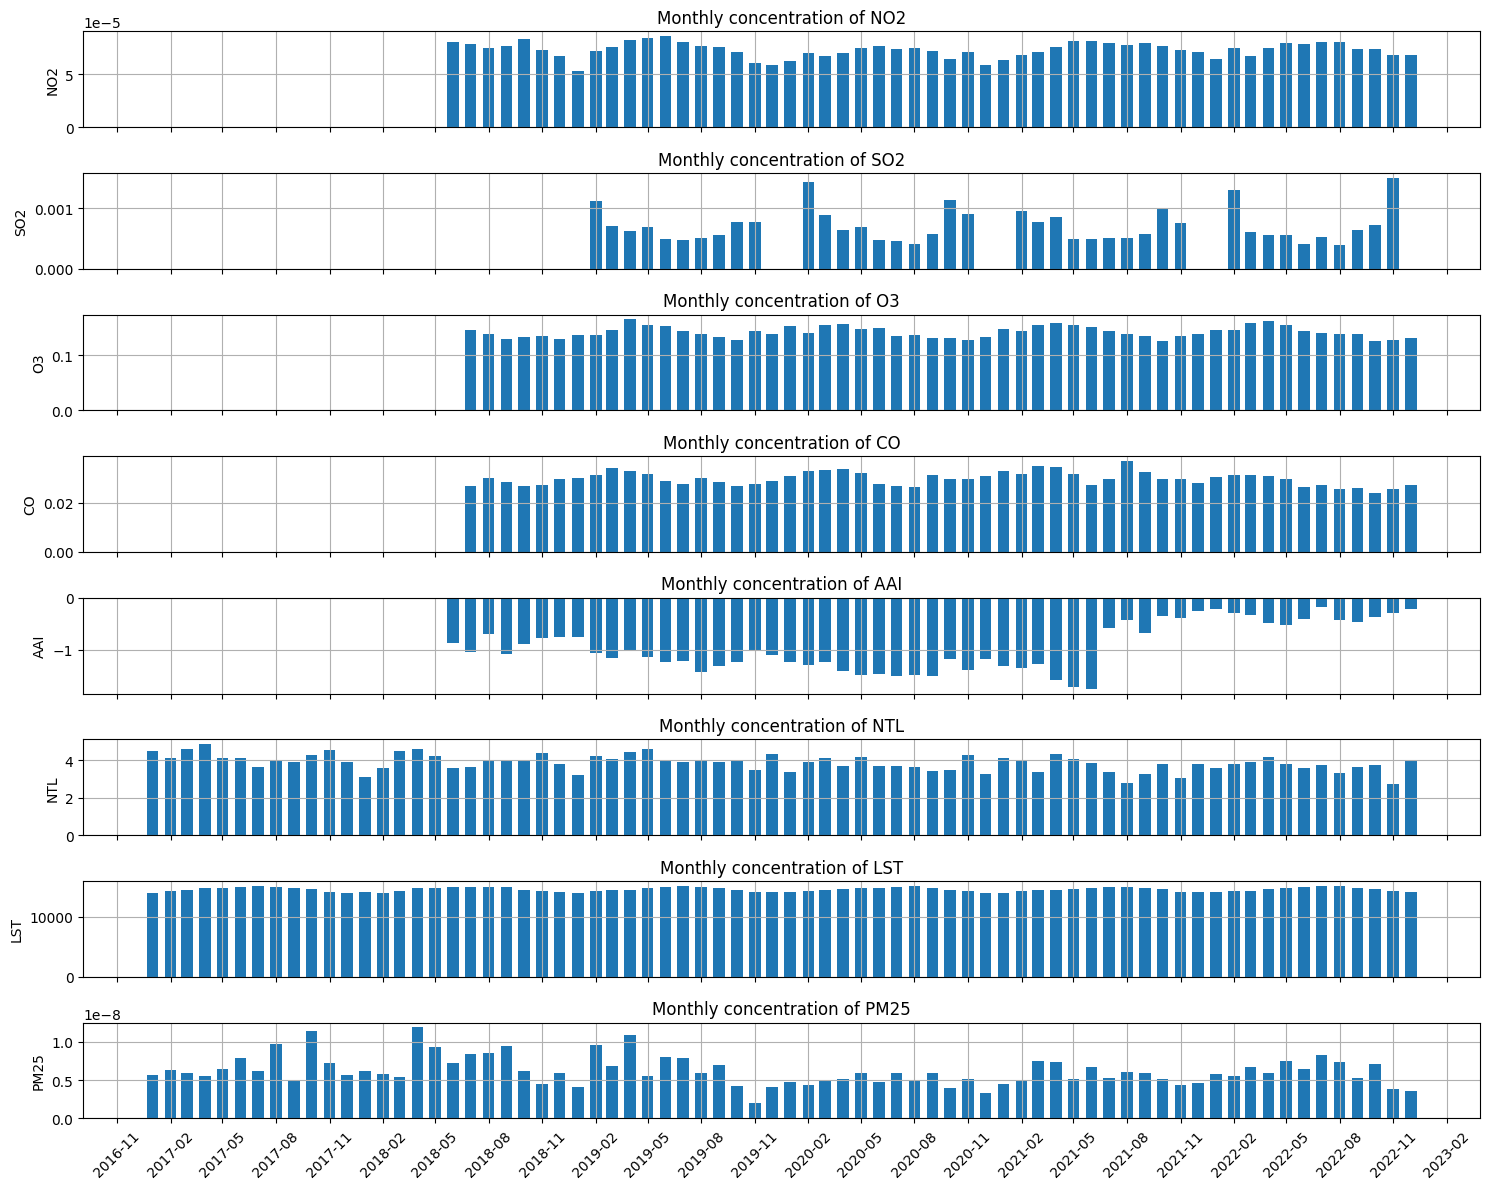

In [81]:
# Graphics
# List of pullutants
import matplotlib.dates as mdates
contaminantes = ['NO2', 'SO2', 'O3', 'CO', 'AAI', 'NTL', 'LST','PM25']

fig, axs = plt.subplots(len(contaminantes), 1, figsize=(15, 12), sharex=True)

for i, cont in enumerate(contaminantes):
    axs[i].bar(df_grouped['date'], df_grouped[cont], width=20)
    axs[i].set_ylabel(cont)
    axs[i].set_title(f'Monthly concentration of {cont}')
    axs[i].grid(True)

# Format x-axis to show year and month
axs[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
axs[-1].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Creating the "has plants" field
Now we need to mark the grids that contain plants in our data frame.

We begin by importing and then converting the plants data frame to GeoDataFrame type.

In [109]:
# We import the plants
output_path = os.path.join(BASE_DIR, "./private/produccion empresas vascas 18-22.xlsx")
df_plants = pd.read_excel(output_path, sheet_name="bd_plantas")

In [86]:
df_plants["geometry"] = df_plants.apply(lambda row: Point(row["Longitud"], row["Latitud"]), axis=1)
gdf_plants = gpd.GeoDataFrame(df_plants, geometry="geometry", crs="EPSG:4326")

# Reproyectar grid al mismo CRS si es necesario
if grid.crs != gdf_plants.crs:
    grid = grid.to_crs(gdf_plants.crs)

In [87]:
# Se une cada planta con el grid en el que cae
plants_with_grid = gpd.sjoin(gdf_plants, grid[["grid_id", "geometry"]], how="left", predicate="within")
plants_with_grid

,EMPRESA,Latitud,Longitud,localidad,provincia,geometry,index_right,grid_id
0,1,43.034900,-3.001310,Amurrio,Alava,POINT (-3.00131 43.0349),1235,1235
1,2,43.295011,-2.910000,Loiu,Vizcaya,POINT (-2.91 43.29501),1825,1825
2,3,43.041698,-2.216001,Olaberría,Guipuzcoa,POINT (-2.216 43.0417),6618,6618
3,4,43.310400,-2.998450,Sestao,Vizcaya,POINT (-2.99845 43.3104),1265,1265
4,5,43.309900,-3.020770,Valle de Trapaga,Vizcaya,POINT (-3.02077 43.3099),1119,1119
5,6,43.299400,-3.006360,Sestao,Vizcaya,POINT (-3.00636 43.2994),1190,1190
6,7,43.268700,-3.153110,Basauri,Vizcaya,POINT (-3.15311 43.2687),515,515
7,8,43.077600,-2.995680,Amurrio,Alava,POINT (-2.99568 43.0776),1240,1240


In [88]:
output_path = os.path.join(BASE_DIR, "grilla_pais_vasco.gpkg" )
grid.to_file(output_path, driver="GPKG")

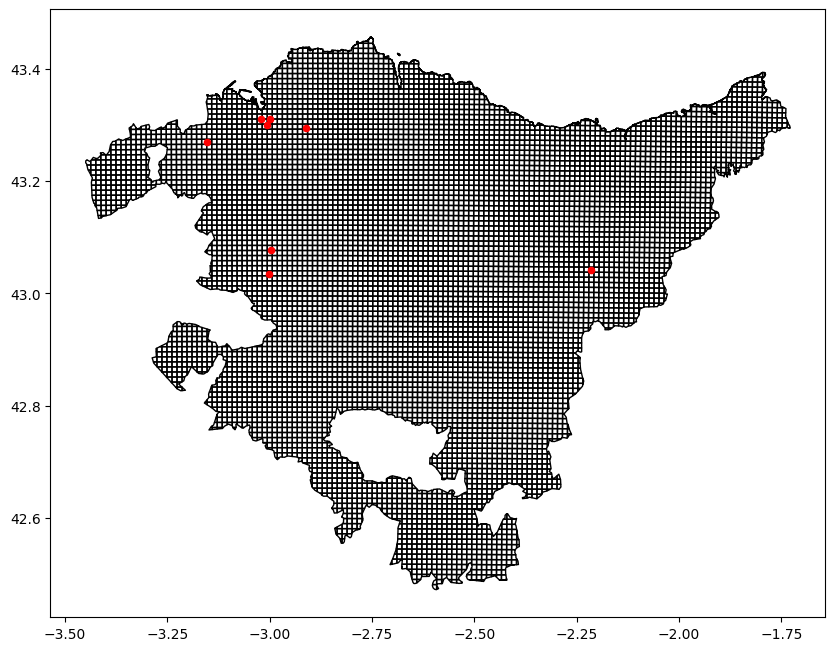

In [90]:
import matplotlib.pyplot as plt

# Draw the grids
grid.plot(edgecolor='black', facecolor='none', figsize=(10, 10))

# Overlap the plant points
gdf_plants.plot(color='red', markersize=20, ax=plt.gca())

plt.show()

In [92]:
print("CRS grid:", grid.crs)
print("CRS plants:", gdf_plants.crs)

CRS grid: EPSG:4326
CRS plants: EPSG:4326


Now, we add to our **consolidated df** the field ***has plant***.

In [93]:
# Extract unique grid_ids with at least one floor
grids_with_planta = plants_with_grid["grid_id"].dropna().unique()

# Mark if a grid_id has a floor
df["tiene_planta"] = df["grid_id"].isin(grids_with_planta).astype(int)

##### Graphics for grids with plan

C:\Users\camil\AppData\Local\Temp\ipykernel_27236\265011239.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_planta['date'] = pd.to_datetime(df_planta[['year', 'month']].assign(day=1))


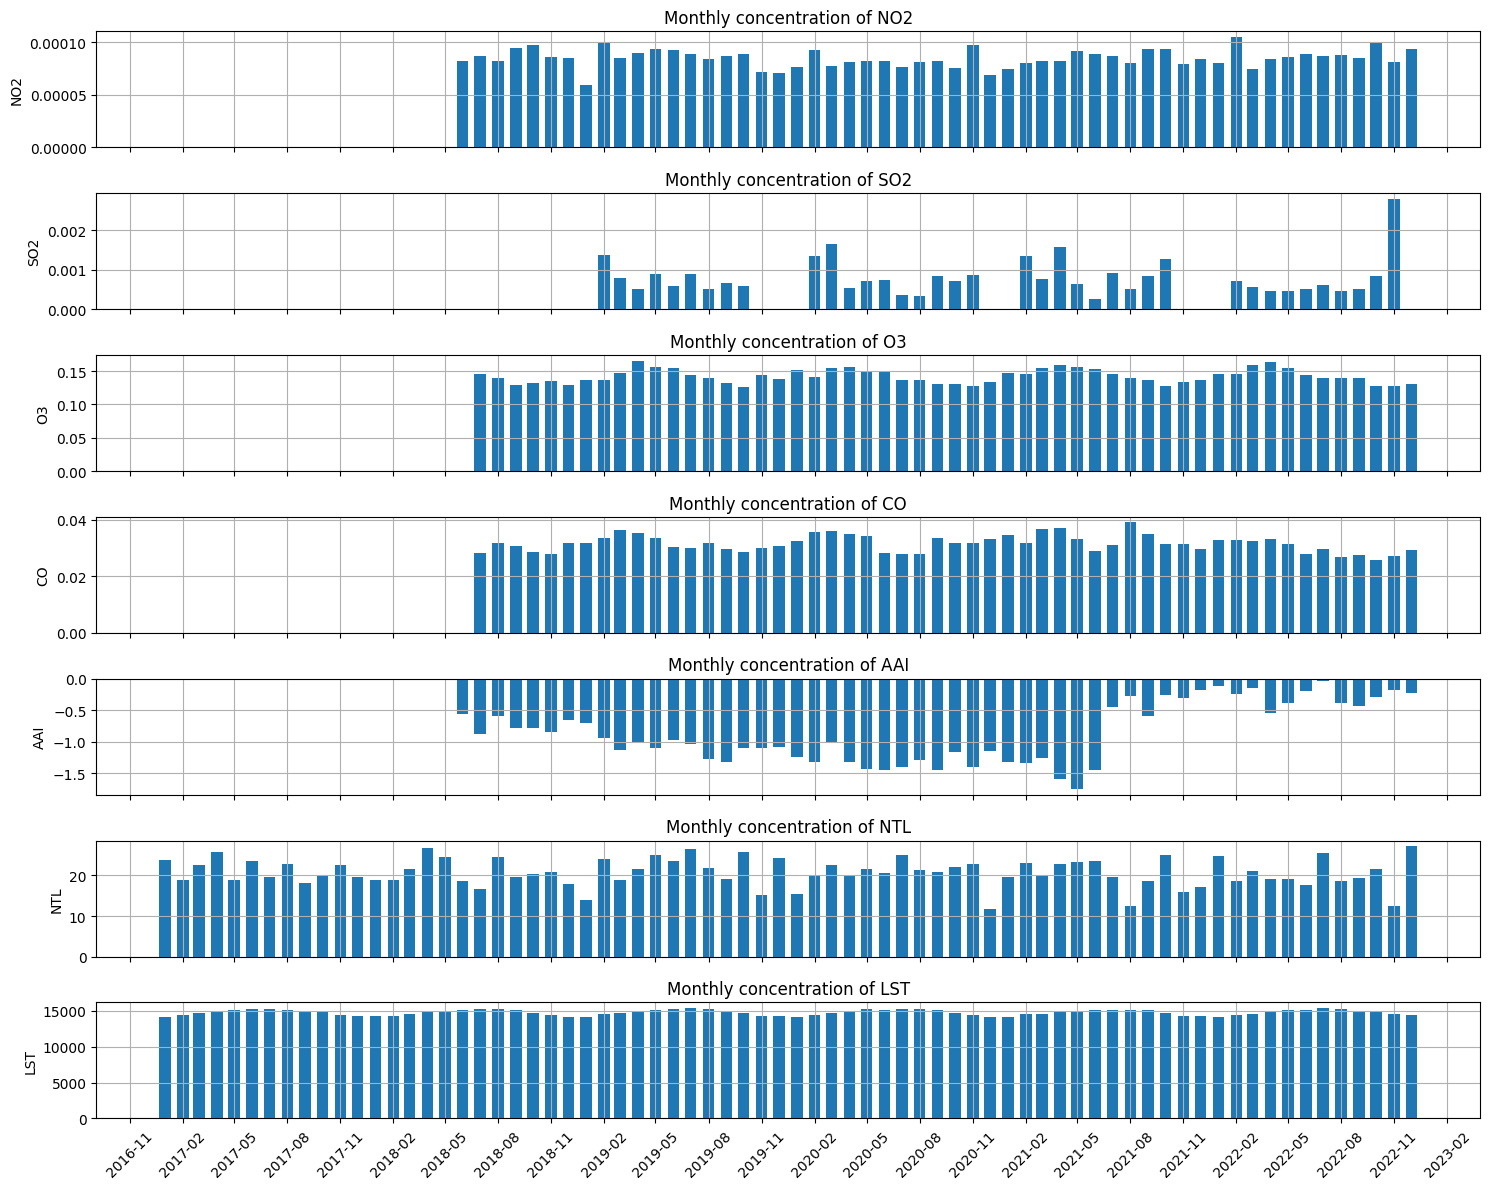

In [96]:
# los grid id con planta son: 1235, 1825, 6618, 1265, 1119, 1190, 515, 1240
df_planta = df[df['grid_id']==1825]
df_planta['date'] = pd.to_datetime(df_planta[['year', 'month']].assign(day=1))
df_planta = df_planta.sort_values('date')

contaminantes = ['NO2', 'SO2', 'O3', 'CO', 'AAI', 'NTL', 'LST']

fig, axs = plt.subplots(len(contaminantes), 1, figsize=(15, 12), sharex=True)

for i, cont in enumerate(contaminantes):
    axs[i].bar(df_planta['date'], df_planta[cont], width=20)
    axs[i].set_ylabel(cont)
    axs[i].set_title(f'Monthly concentration of {cont}')
    axs[i].grid(True)

# Formatear eje x para mostrar año y mes
axs[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
axs[-1].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


## We added a production level to the grids with production

In [97]:
# We import production by company
output_path = os.path.join(BASE_DIR, "./private/produccion empresas vascas 18-22.xlsx")
df_produccion = pd.read_excel(output_path, sheet_name="bd_produccion")

In [102]:
# Asociamos cada empresa a su grid
empresa_grid = plants_with_grid[['EMPRESA', 'grid_id']]
df_produccion = df_produccion.merge(empresa_grid, on = 'grid_id', how = 'left')

# Calculo de produccion por grid
produccion_grid = df_produccion.groupby(['grid_id','year','month'])['produccion'].sum().reset_index()

In [103]:
# Agregamos la producción al df consolidad
df = df.merge(produccion_grid, on = ['grid_id','year','month'], how = 'left')

In [104]:
# Save df
output_path = os.path.join(BASE_DIR, "bd_consolidado.csv")
df.to_csv(output_path, index=False)

#### Transformación de PM25

In [106]:
output_path = os.path.join(BASE_DIR, "bd_consolidado.csv")
df = pd.read_csv(output_path)

In [107]:
df['PM25'] = df['PM25']*1000000

In [108]:
# Save df
output_path = os.path.join(BASE_DIR, "bd_consolidado.csv")
df.to_csv(output_path, index=False)

### Download of daily SO2 data for two months
This download is performed to validate that we have no data for any day in months where all grids are missing.

In [ ]:
def extract_daily_SO2(year, month, gdf_points, chunk_size=1000):
    from calendar import monthrange

    days_in_month = monthrange(year, month)[1]
    all_data = []

    for day in range(1, days_in_month + 1):
        date = datetime(year, month, day)
        next_day = date + timedelta(days=1)

        collection = ee.ImageCollection("COPERNICUS/S5P/NRTI/L3_SO2") \
            .filterDate(date.strftime('%Y-%m-%d'), next_day.strftime('%Y-%m-%d')) \
            .select("SO2_column_number_density")

        size = collection.size().getInfo()
        if size == 0:
            print(f"No hay datos para {date.strftime('%Y-%m-%d')}")
            continue

        image = collection.mean()

        for chunk in split_gdf(gdf_points, chunk_size):
            fc_chunk = geodf_to_fc(chunk)
            results = image.reduceRegions(
                collection=fc_chunk,
                reducer=ee.Reducer.mean(),
                scale=1000
            ).getInfo()

            for f in results["features"]:
                props = f["properties"]
                all_data.append({
                    "grid_id": props["grid_id"],
                    "SO2": props.get("mean", None),
                    "date": date.strftime('%Y-%m-%d')
                })

    return all_data

from datetime import datetime, timedelta

# Extraer datos diarios de SO2 para diciembre 2018
data_nov_2019 = extract_daily_SO2(2019, 11, points)

# Crear DataFrame
df_SO2_nov_2019 = pd.DataFrame(data_nov_2019)


In [ ]:
df_SO2_nov_2019.to_csv("SO2_diario_por_grid_nov2019.csv", index=False)

In [ ]:
def extract_daily_SO2(year, month, gdf_points, chunk_size=1000):
    from calendar import monthrange

    days_in_month = monthrange(year, month)[1]
    all_data = []

    for day in range(1, days_in_month + 1):
        date = datetime(year, month, day)
        next_day = date + timedelta(days=1)

        collection = ee.ImageCollection("COPERNICUS/S5P/NRTI/L3_SO2") \
            .filterDate(date.strftime('%Y-%m-%d'), next_day.strftime('%Y-%m-%d')) \
            .select("SO2_column_number_density")

        size = collection.size().getInfo()
        if size == 0:
            print(f"No hay datos para {date.strftime('%Y-%m-%d')}")
            continue

        image = collection.mean()

        for chunk in split_gdf(gdf_points, chunk_size):
            fc_chunk = geodf_to_fc(chunk)
            results = image.reduceRegions(
                collection=fc_chunk,
                reducer=ee.Reducer.mean(),
                scale=1000
            ).getInfo()

            for f in results["features"]:
                props = f["properties"]
                all_data.append({
                    "grid_id": props["grid_id"],
                    "SO2": props.get("mean", None),
                    "date": date.strftime('%Y-%m-%d')
                })

    return all_data

from datetime import datetime, timedelta

# Extraer datos diarios de SO2 para diciembre 2020
data_jun_2020 = extract_daily_SO2(2020, 6, points)

# Crear DataFrame
df_SO2_jun_2020 = pd.DataFrame(data_jun_2020)

In [ ]:
df_SO2_jun_2020.to_csv("SO2_diario_por_grid_jun2020.csv", index=False)

## Download SO2 from NASA's OMI/AURA Project
The OMI/AURA product is an excellent alternative for imputing missing SO₂ values, especially on dates when Sentinel-5P has no coverage. Although OMI's spatial resolution (13×24 km) is lower than that of Sentinel-5P (7×3.5 km or better), it is still useful for filling gaps or performing complementary analyses.

**Methodology**:
- A text file was generated directly on the https://search.earthdata.nasa.gov/ page with the necessary data (date, zone, and pollutant filters). This text file was saved. It contains a download link for each day in the filtered time series.
- The download of each file (2,866 .he5 files) was automated.
- These files were read in Jupyter using a function that stored the SO2 level for each of our grids in a daily series. The strategy for cross-referencing our grids was as follows: Each polygon of the OMI pixel intersected with all of our grids (approximately 312 grids will have the same value), and for grids located between two larger grids, the OMI grid values ​​were averaged.
- In a failed attempt, I noticed many days with negative values ​​and others with extremely negative values ​​(-6e32 and higher). This is a strategy to identify missing data in the source. Therefore, before performing the aggregation Monthly:

- Less than 0 → 0.

- Less than -1000 → NaN.

- We aggregate SO2 levels at the grid level using the monthly average.

In [ ]:
netrc_path = os.path.expanduser("~/.netrc")

with open(netrc_path, "w") as f:
    f.write("machine urs.earthdata.nasa.gov\n")
    f.write("login cvalladares\n")
    f.write("password 12011991Naci.\n")

os.chmod(netrc_path, 0o600)  # Seguridad del archivo

print(f"✅ Archivo .netrc creado en: {netrc_path}")

✅ Archivo .netrc creado en: C:\Users\camil/.netrc


In [ ]:
import requests
from getpass import getpass
import os

# Leer URLs
with open("OMSO2.txt", "r") as file:
    urls = [line.strip() for line in file if line.strip().endswith(".he5")]

# Credenciales
username = input("Usuario Earthdata (cvalladares): ")
password = getpass("Contraseña Earthdata(12011991Naci.): ")

# Carpeta de descarga
save_dir = "descargas_omi"
os.makedirs(save_dir, exist_ok=True)

# Sesión autenticada
session = requests.Session()
session.auth = (username, password)
session.headers.update({
    "User-Agent": "earthdata-downloader",
    "Accept": "*/*"
})

# IMPORTANTE: Login primero en el dominio de autenticación
login_url = "https://urs.earthdata.nasa.gov"
session.get(login_url)

# Descargar archivos
for url in urls:
    filename = os.path.join(save_dir, os.path.basename(url))
    if os.path.exists(filename):
        print(f"Ya existe: {filename}, omitiendo descarga.")
        continue
    print(f"Descargando: {filename}")
    with session.get(url, stream=True, allow_redirects=True) as r:
        if r.status_code == 200:
            with open(filename, "wb") as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)
        else:
            print(f"❌ Error {r.status_code} al descargar: {url}")


Usuario Earthdata (cvalladares): cvalladares
Contraseña Earthdata(12011991Naci.): ········
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m0101t1213-o71622_v003-2020m0222t183616.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m0102t1117-o71636_v003-2020m0222t183151.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m0102t1256-o71637_v003-2020m0222t183142.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m0103t1200-o71651_v003-2020m0222t183544.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m0104t1105-o71665_v003-2020m0222t183504.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m0104t1244-o71666_v003-2020m0222t183457.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m0105t1148-o71680_v003-2020m0222t183410.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m0105t1327-o71681_v003-2020m0222t183410.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m0106t1231-o71695_v003-2020m0222t184121.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m0107t1136-o71709_v003-

Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m0301t1159-o72481_v003-2020m0222t194325.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m0302t1104-o72495_v003-2020m0222t194305.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m0302t1243-o72496_v003-2020m0222t194304.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m0303t1147-o72510_v003-2020m0222t195115.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m0303t1326-o72511_v003-2020m0222t195115.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m0304t1230-o72525_v003-2020m0222t194918.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m0305t1135-o72539_v003-2020m0222t194843.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m0305t1314-o72540_v003-2020m0222t194839.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m0306t1218-o72554_v003-2020m0222t195424.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m0307t1123-o72568_v003-2020m0222t195401.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m0307t1302-o72569_v00

Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m0427t1338-o73312_v003-2020m0222t205250.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m0428t1243-o73326_v003-2020m0222t205258.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m0429t1147-o73340_v003-2020m0222t205309.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m0429t1326-o73341_v003-2020m0222t205249.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m0430t1231-o73355_v003-2020m0222t205302.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m0501t1135-o73369_v003-2020m0222t205824.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m0501t1314-o73370_v003-2020m0222t205824.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m0502t1218-o73384_v003-2020m0222t205819.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m0503t1123-o73398_v003-2020m0222t205754.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m0503t1302-o73399_v003-2020m0222t205803.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m0504t1206-o73413_v00

Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m0619t2353-o74090_v003-2020m0222t221937.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m0620t1125-o74097_v003-2020m0222t221926.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m0620t1304-o74098_v003-2020m0222t221926.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m0621t0036-o74105_v003-2020m0222t222136.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m0621t1208-o74112_v003-2020m0222t221704.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m0622t0119-o74120_v003-2020m0222t221651.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m0622t1112-o74126_v003-2020m0222t221623.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m0622t1251-o74127_v003-2020m0222t221611.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m0623t0202-o74135_v003-2020m0222t222328.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m0623t1156-o74141_v003-2020m0222t222257.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m0623t1334-o74142_v00

Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m0810t1153-o74840_v003-2020m0222t234115.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m0810t1332-o74841_v003-2020m0222t234127.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m0811t1236-o74855_v003-2020m0222t234408.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m0812t0008-o74862_v003-2020m0222t235023.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m0812t1141-o74869_v003-2020m0222t234712.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m0812t1319-o74870_v003-2020m0222t234653.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m0813t0052-o74877_v003-2020m0222t234650.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m0813t1224-o74884_v003-2020m0222t234645.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m0814t0135-o74892_v003-2020m0222t234700.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m0814t1128-o74898_v003-2020m0222t234639.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m0814t1307-o74899_v00

Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m1004t1153-o75641_v003-2020m0223t005720.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m1004t1332-o75642_v003-2020m0223t010035.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m1005t1237-o75656_v003-2020m0223t010005.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m1006t1141-o75670_v003-2020m0223t005927.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m1006t1320-o75671_v003-2020m0223t005926.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m1007t1224-o75685_v003-2020m0223t010211.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m1008t1128-o75699_v003-2020m0223t010453.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m1008t1307-o75700_v003-2020m0223t010439.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m1009t1211-o75714_v003-2020m0223t010515.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m1010t1116-o75728_v003-2020m0223t010512.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m1010t1254-o75729_v00

Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m1202t1308-o76501_v003-2020m0223t022343.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m1203t1212-o76515_v003-2020m0223t022316.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m1204t1117-o76529_v003-2020m0223t022156.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m1204t1256-o76530_v003-2020m0223t022156.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m1205t1200-o76544_v003-2020m0223t023826.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m1206t1104-o76558_v003-2020m0223t022820.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m1206t1243-o76559_v003-2020m0223t022811.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m1207t1148-o76573_v003-2020m0223t022731.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m1207t1326-o76574_v003-2020m0223t022722.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m1208t1231-o76588_v003-2020m0223t023549.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2018m1209t1135-o76602_v00

Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m0131t1156-o77374_v003-2020m0223t035055.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m0201t1100-o77388_v003-2020m0223t034950.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m0201t1239-o77389_v003-2020m0223t034942.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m0202t1143-o77403_v003-2020m0223t035319.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m0202t1322-o77404_v003-2020m0223t035315.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m0203t1227-o77418_v003-2020m0223t035200.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m0204t1131-o77432_v003-2020m0223t040333.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m0204t1310-o77433_v003-2020m0223t040347.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m0205t1215-o77447_v003-2020m0223t035806.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m0206t1119-o77461_v003-2020m0223t035439.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m0206t1258-o77462_v00

Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m0330t1240-o78219_v003-2020m0223t052321.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m0331t1144-o78233_v003-2020m0223t052252.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m0331t1323-o78234_v003-2020m0223t052258.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m0401t1227-o78248_v003-2020m0223t052222.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m0403t1215-o78277_v003-2020m0223t053725.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m0404t1120-o78291_v003-2020m0223t053711.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m0404t1259-o78292_v003-2020m0223t053710.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m0405t1203-o78306_v003-2020m0223t053653.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m0406t1108-o78320_v003-2020m0223t053733.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m0406t1247-o78321_v003-2020m0223t053731.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m0407t1151-o78335_v00

Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m0524t1250-o79020_v003-2020m0223t070626.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m0525t1155-o79034_v003-2020m0223t070759.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m0525t1334-o79035_v003-2020m0223t070757.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m0526t1238-o79049_v003-2020m0223t071723.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m0527t0010-o79056_v003-2020m0223t071703.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m0527t1142-o79063_v003-2020m0223t071649.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m0527t1321-o79064_v003-2020m0223t071637.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m0528t0054-o79071_v003-2020m0223t071613.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m0528t1226-o79078_v003-2020m0223t071533.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m0529t0137-o79086_v003-2020m0223t071533.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m0529t1130-o79092_v00

Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m0714t1142-o79762_v003-2020m0223t083420.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m0714t1321-o79763_v003-2020m0223t083413.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m0715t1225-o79777_v003-2020m0223t083330.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m0716t1130-o79791_v003-2020m0223t083256.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m0716t1309-o79792_v003-2020m0223t083249.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m0717t1213-o79806_v003-2020m0223t083203.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m0718t1117-o79820_v003-2020m0223t084002.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m0718t1256-o79821_v003-2020m0223t083954.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m0719t1200-o79835_v003-2020m0223t083633.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m0719t1339-o79836_v003-2020m0223t083624.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m0720t1244-o79850_v00

Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m0905t1335-o80535_v003-2020m0223t094852.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m0906t1240-o80549_v003-2020m0223t094925.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m0907t1144-o80563_v003-2020m0223t094906.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m0907t1323-o80564_v003-2020m0223t094929.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m0908t1227-o80578_v003-2020m0223t095427.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m0910t1215-o80607_v003-2020m0223t095137.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m0911t1119-o80621_v003-2020m0223t095130.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m0911t1258-o80622_v003-2020m0223t095127.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m0912t1202-o80636_v003-2020m0223t095121.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m0913t1106-o80650_v003-2020m0223t095655.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m0913t1245-o80651_v00

Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m1104t1215-o81408_v003-2020m0223t111256.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m1105t1119-o81422_v003-2020m0223t112033.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m1105t1258-o81423_v003-2020m0223t112040.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m1106t1202-o81437_v003-2020m0223t112014.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m1107t1106-o81451_v003-2020m0223t111828.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m1107t1245-o81452_v003-2020m0223t111842.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m1108t1149-o81466_v003-2020m0223t111827.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m1108t1328-o81467_v003-2020m0223t111820.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m1109t1233-o81481_v003-2020m0223t111817.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m1110t1137-o81495_v003-2020m0223t111833.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2019m1110t1316-o81496_v00

Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m0101t1110-o82252_v003-2020m0223t134908.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m0101t1249-o82253_v003-2020m0223t134849.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m0102t1154-o82267_v003-2020m0223t134840.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m0103t1058-o82281_v003-2020m0223t134750.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m0103t1237-o82282_v003-2020m0223t134726.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m0104t1141-o82296_v003-2020m0223t134723.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m0104t1320-o82297_v003-2020m0223t134713.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m0105t1225-o82311_v003-2020m0223t135517.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m0106t1129-o82325_v003-2020m0223t135415.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m0106t1308-o82326_v003-2020m0223t135423.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m0107t1212-o82340_v00

Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m0227t1109-o83082_v003-2020m0228t031848.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m0227t1248-o83083_v003-2020m0228t031837.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m0228t1152-o83097_v003-2020m0229t125148.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m0228t1331-o83098_v003-2020m0229t130215.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m0229t1236-o83112_v003-2020m0301t123906.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m0301t1140-o83126_v003-2020m0302t192149.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m0301t1319-o83127_v003-2020m0302t192155.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m0302t1224-o83141_v003-2020m0303t030620.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m0303t1128-o83155_v003-2020m0304t032807.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m0303t1307-o83156_v003-2020m0304t032802.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m0304t1211-o83170_v00

Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m0424t1109-o83912_v003-2020m0425t121729.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m0424t1248-o83913_v003-2020m0425t122324.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m0425t1153-o83927_v003-2020m0426t142106.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m0425t1332-o83928_v003-2020m0426t142102.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m0426t1236-o83942_v003-2020m0427t065222.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m0427t1140-o83956_v003-2020m0428t031620.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m0427t1319-o83957_v003-2020m0428t031121.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m0428t1224-o83971_v003-2020m0429t033515.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m0429t1128-o83985_v003-2020m0430t035432.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m0429t1307-o83986_v003-2020m0430t163226.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m0430t1212-o84000_v00

Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m0619t1340-o84729_v003-2020m0620t131423.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m0620t1245-o84743_v003-2020m0621t112830.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m0621t1149-o84757_v003-2020m0622t023249.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m0621t1328-o84758_v003-2020m0622t024826.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m0622t1232-o84772_v003-2020m0623t023935.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m0623t1137-o84786_v003-2020m0624t044650.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m0623t1316-o84787_v003-2020m0624t043739.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m0624t1220-o84801_v003-2020m0625t023031.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m0625t1124-o84815_v003-2020m0626t124724.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m0625t1303-o84816_v003-2020m0626t164028.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m0626t1208-o84830_v00

Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m0815t1331-o85559_v003-2020m0816t114557.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m0816t1236-o85573_v003-2020m0817t035037.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m0817t1140-o85587_v003-2020m0818t034509.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m0817t1319-o85588_v003-2020m0818t034456.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m0818t1223-o85602_v003-2020m0819t042102.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m0819t1128-o85616_v003-2020m0820t053641.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m0819t1306-o85617_v003-2020m0820t173227.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m0820t1211-o85631_v003-2020m0821t031543.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m0821t1115-o85645_v003-2020m0822t121037.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m0821t1254-o85646_v003-2020m0822t121036.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m0822t1158-o85660_v00

Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m1011t1319-o86389_v003-2020m1012t111944.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m1012t1223-o86403_v003-2020m1013t140159.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m1013t1128-o86417_v003-2020m1014t035134.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m1013t1307-o86418_v003-2020m1014t035132.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m1014t1211-o86432_v003-2020m1015t023030.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m1015t1115-o86446_v003-2020m1016t124550.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m1015t1254-o86447_v003-2020m1016t124442.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m1016t1158-o86461_v003-2020m1017t122605.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m1017t1103-o86475_v003-2020m1018t121324.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m1017t1241-o86476_v003-2020m1018t121328.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m1018t1146-o86490_v00

Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m1207t1308-o87219_v003-2020m1208t031205.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m1208t1212-o87233_v003-2020m1209t025956.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m1209t1117-o87247_v003-2020m1210t041929.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m1209t1255-o87248_v003-2020m1210t043015.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m1210t1200-o87262_v003-2020m1210t205154.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m1211t1104-o87276_v003-2020m1211t215624.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m1211t1243-o87277_v003-2020m1211t205755.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m1212t1147-o87291_v003-2020m1212t204305.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m1212t1326-o87292_v003-2020m1213t123533.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m1213t1231-o87306_v003-2020m1213t231257.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2020m1214t1135-o87320_v00

Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m0202t1304-o88049_v003-2021m0203t023014.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m0203t1208-o88063_v003-2021m0204t031513.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m0204t1113-o88077_v003-2021m0204t211950.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m0204t1251-o88078_v003-2021m0205t040743.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m0205t1156-o88092_v003-2021m0206t031048.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m0206t1100-o88106_v003-2021m0206t210117.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m0206t1239-o88107_v003-2021m0207t125528.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m0207t1144-o88121_v003-2021m0208t043358.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m0207t1323-o88122_v003-2021m0208t042801.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m0208t1227-o88136_v003-2021m0209t042646.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m0209t1132-o88150_v00

Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m0331t1304-o88879_v003-2021m0401t024903.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m0401t1208-o88893_v003-2021m0402t025034.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m0402t1113-o88907_v003-2021m0402t210921.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m0402t1252-o88908_v003-2021m0403t143038.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m0403t1156-o88922_v003-2021m0404t114321.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m0403t1335-o88923_v003-2021m0404t114322.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m0404t1240-o88937_v003-2021m0405t034015.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m0405t1144-o88951_v003-2021m0406t032041.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m0405t1323-o88952_v003-2021m0406t032033.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m0406t1228-o88966_v003-2021m0407t042533.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m0407t1132-o88980_v00

Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m0527t1303-o89709_v003-2021m0528t030818.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m0528t1207-o89723_v003-2021m0529t130146.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m0529t1111-o89737_v003-2021m0529t205851.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m0529t1250-o89738_v003-2021m0530t113138.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m0530t1155-o89752_v003-2021m0531t023827.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m0530t1334-o89753_v003-2021m0531t023820.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m0531t1238-o89767_v003-2021m0601t023930.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m0601t1142-o89781_v003-2021m0602t032832.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m0601t1321-o89782_v003-2021m0602t033342.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m0602t1226-o89796_v003-2021m0603t030002.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m0603t1130-o89810_v00

Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m0723t1256-o90539_v003-2021m0724t142408.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m0724t1200-o90553_v003-2021m0725t114449.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m0724t1339-o90554_v003-2021m0725t114915.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m0725t1243-o90568_v003-2021m0726t024330.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m0726t1148-o90582_v003-2021m0727t030440.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m0726t1327-o90583_v003-2021m0727t030440.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m0727t1231-o90597_v003-2021m0728t044122.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m0728t1135-o90611_v003-2021m0729t034035.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m0728t1314-o90612_v003-2021m0729t034026.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m0729t1218-o90626_v003-2021m0730t031223.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m0730t1123-o90640_v00

Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m0918t1245-o91369_v003-2021m0919t115257.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m0919t1149-o91383_v003-2021m0920t140653.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m0919t1328-o91384_v003-2021m0920t140657.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m0920t1232-o91398_v003-2021m0921t024329.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m0921t1136-o91412_v003-2021m0922t022240.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m0921t1315-o91413_v003-2021m0922t022243.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m0922t1220-o91427_v003-2021m0923t025409.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m0923t1124-o91441_v003-2021m0923t205629.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m0923t1303-o91442_v003-2021m0924t023051.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m0924t1207-o91456_v003-2021m0925t152439.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m0925t1111-o91470_v00

Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m1114t1232-o92199_v003-2021m1115t034133.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m1115t1137-o92213_v003-2021m1116t034229.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m1115t1315-o92214_v003-2021m1116t033145.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m1116t1220-o92228_v003-2021m1117t030319.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m1117t1124-o92242_v003-2021m1117t222523.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m1117t1303-o92243_v003-2021m1118t052036.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m1118t1207-o92257_v003-2021m1119t030445.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m1119t1112-o92271_v003-2021m1119t205051.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m1119t1250-o92272_v003-2021m1120t024347.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m1120t1155-o92286_v003-2021m1121t124638.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2021m1121t1059-o92300_v00

Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m0110t1225-o93029_v003-2022m0111t023010.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m0111t1129-o93043_v003-2022m0111t204055.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m0111t1308-o93044_v003-2022m0112t031952.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m0112t1213-o93058_v003-2022m0113t025909.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m0113t1117-o93072_v003-2022m0113t220548.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m0113t1256-o93073_v003-2022m0114t045539.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m0114t1200-o93087_v003-2022m0115t132141.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m0115t1105-o93101_v003-2022m0115t213709.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m0115t1244-o93102_v003-2022m0116t125314.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m0116t1148-o93116_v003-2022m0117t115145.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m0116t1327-o93117_v00

Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m0308t1225-o93859_v003-2022m0309t024955.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m0309t1129-o93873_v003-2022m0309t205323.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m0309t1308-o93874_v003-2022m0310t031434.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m0310t1213-o93888_v003-2022m0311t023714.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m0311t1117-o93902_v003-2022m0311t204045.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m0311t1256-o93903_v003-2022m0312t030038.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m0312t1200-o93917_v003-2022m0313t125409.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m0313t1105-o93931_v003-2022m0314t020308.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m0313t1244-o93932_v003-2022m0314t042323.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m0314t1148-o93946_v003-2022m0315t031026.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m0314t1327-o93947_v00

Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m0504t1225-o94689_v003-2022m0505t030845.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m0505t1129-o94703_v003-2022m0505t202619.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m0505t1308-o94704_v003-2022m0506t025434.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m0506t1212-o94718_v003-2022m0507t153306.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m0507t1117-o94732_v003-2022m0507t212737.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m0507t1256-o94733_v003-2022m0508t112948.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m0508t1200-o94747_v003-2022m0509t054851.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m0508t1339-o94748_v003-2022m0509t054025.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m0509t1244-o94762_v003-2022m0510t042316.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m0510t1148-o94776_v003-2022m0511t041450.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m0510t1327-o94777_v00

Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m0630t1220-o95519_v003-2022m0701t144058.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m0701t1125-o95533_v003-2022m0705t142250.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m0701t1304-o95534_v003-2022m0701t215656.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m0702t1208-o95548_v003-2022m0705t142251.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m0703t1112-o95562_v003-2022m0705t141747.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m0703t1251-o95563_v003-2022m0703t221730.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m0704t1156-o95577_v003-2022m0705t141236.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m0704t1334-o95578_v003-2022m0705t142248.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m0705t1239-o95592_v003-2022m0711t125107.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m0706t1143-o95606_v003-2022m0711t125608.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m0706t1322-o95607_v00

Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m0828t1158-o96378_v003-2022m0829t035234.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m0828t1337-o96379_v003-2022m0829t034736.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m0829t1241-o96393_v003-2022m0830t024041.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m0830t1145-o96407_v003-2022m0831t121540.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m0830t1324-o96408_v003-2022m0831t121540.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m0831t1229-o96422_v003-2022m0901t023939.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m0901t1133-o96436_v003-2022m0902t024550.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m0901t1312-o96437_v003-2022m0902t025124.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m0902t1216-o96451_v003-2022m0904t121634.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m0903t1120-o96465_v003-2022m0904t121641.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m0903t1259-o96466_v00

Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m1024t1145-o97208_v003-2022m1025t120948.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m1024t1324-o97209_v003-2022m1025t120945.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m1025t1229-o97223_v003-2022m1026t042219.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m1026t1133-o97237_v003-2022m1027t025359.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m1026t1312-o97238_v003-2022m1027t025401.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m1027t1216-o97252_v003-2022m1028t024638.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m1028t1120-o97266_v003-2022m1028t205951.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m1028t1259-o97267_v003-2022m1029t025421.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m1029t1203-o97281_v003-2022m1030t115625.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m1030t1108-o97295_v003-2022m1030t204835.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m1030t1247-o97296_v00

Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m1220t1136-o98038_v003-2022m1221t044438.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m1220t1315-o98039_v003-2022m1221t044442.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m1221t1219-o98053_v003-2022m1222t025757.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m1222t1124-o98067_v003-2022m1222t205243.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m1222t1303-o98068_v003-2022m1223t030824.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m1223t1207-o98082_v003-2022m1224t170455.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m1224t1111-o98096_v003-2022m1224t222738.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m1224t1250-o98097_v003-2022m1225t130829.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m1225t1155-o98111_v003-2022m1226t062112.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m1226t1059-o98125_v003-2022m1226t211617.he5
Descargando: descargas_omi\OMI-Aura_L2-OMSO2_2022m1226t1238-o98126_v00

Con la celda anterior terminamos la descarga de archivos con los datos. A continuación los procesamos para crear nuestro data frame.

In [ ]:
import os
import h5py
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from tqdm import tqdm
from shapely.geometry import Polygon
import re

# === 1. Cargar tus grids del País Vasco ===
gdf_grid = gpd.read_file("grilla_1km_pais_vasco.geojson")  # o .geojson, .gpkg
gdf_grid = gdf_grid.to_crs(epsg=4326)  # asegúrate de usar lat/lon
gdf_grid = gdf_grid[["grid_id", "geometry"]]  # solo columnas necesarias

# === 2. Carpeta de archivos OMI ===
folder = "descargas_omi"
files = sorted([f for f in os.listdir(folder) if f.endswith(".he5")])

In [ ]:
# === 3. Función para procesar un archivo ===
def procesar_archivo(fname, gdf_grid):
    try:
        path = os.path.join(folder, fname)
        with h5py.File(path, "r") as f:
            so2 = f["HDFEOS/SWATHS/OMI Total Column Amount SO2/Data Fields/ColumnAmountSO2"][:]
            lat = f["HDFEOS/SWATHS/OMI Total Column Amount SO2/Geolocation Fields/Latitude"][:]
            lon = f["HDFEOS/SWATHS/OMI Total Column Amount SO2/Geolocation Fields/Longitude"][:]

        rows, cols = so2.shape
        records = []

        for i in range(rows - 1):
            for j in range(cols - 1):
                # Coordenadas del píxel como polígono
                latitudes = [lat[i, j], lat[i, j+1], lat[i+1, j+1], lat[i+1, j]]
                longitudes = [lon[i, j], lon[i, j+1], lon[i+1, j+1], lon[i+1, j]]

                if np.any(np.isnan(latitudes)) or np.any(np.isnan(longitudes)):
                    continue

                polygon = Polygon(zip(longitudes, latitudes))
                valor_so2 = so2[i, j]

                # Reglas para valores
                if valor_so2 < -1000:
                    valor_so2 = np.nan
                elif valor_so2 < 0:
                    valor_so2 = 0

                records.append({"geometry": polygon, "SO2": valor_so2})

        if not records:
            return None

        gdf_omi = gpd.GeoDataFrame(records, crs="EPSG:4326")

        # Cruce espacial por intersección (más preciso que "within")
        gdf_joined = gpd.sjoin(gdf_grid, gdf_omi, how="inner", predicate="intersects")

        # Extraer fecha
        match = re.search(r"(\d{4})m(\d{2})\d{2}t", fname)
        if match:
            anio = int(match.group(1))
            mes = int(match.group(2))
        else:
            raise ValueError(f"No se pudo extraer la fecha del archivo: {fname}")

        gdf_joined["year"] = anio
        gdf_joined["month"] = mes

        return gdf_joined[["grid_id", "SO2", "year", "month"]]

    except Exception as e:
        print(f"❌ Error procesando {fname}: {e}")
        return None


In [ ]:
# === 4. Procesar todos los archivos ===
resultados = []

for fname in tqdm(files):
    resultado = procesar_archivo(fname, gdf_grid)
    if resultado is not None and not resultado.empty:
        resultados.append(resultado)

# === 5. Unir y agregar por grid/mes ===
if resultados:
    df_all = pd.concat(resultados)
    df_monthly = df_all.groupby(["grid_id", "year", "month"], as_index=False).mean()
    df_monthly.to_csv("SO2_OMI_por_grid_mensual.csv", index=False)
    print("✅ Archivo guardado: SO2_OMI_por_grid_mensual.csv")
else:
    print("❌ No se extrajo ningún dato válido.")

100%|████████████████████████████████████████████████████████████████████████████| 2866/2866 [3:37:33<00:00,  4.55s/it]


✅ Archivo guardado: SO2_OMI_por_grid_mensual.csv


In [ ]:
# Filtra los que no son None (por si hubo errores)
resultados_validos = [r for r in resultados if r is not None]

# Unir en un único DataFrame
df_omi = pd.concat(resultados_validos, ignore_index=True)